# FabFitFun Coding Challenge - Slide 4 #

Author: Kimberly Insigne

This notebook contains analysis for transaction data from a flash sale on the FabFitFun website.
`product_data.xlsx` contains product IDs and product names. `sale_data.xlsx` contains member IDs,
product IDs, and quantity of each item purchased.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter
from scipy import stats

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Kimberly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
product_data = pd.read_excel('product_data.xlsx')
sale_data = pd.read_excel('sale_data.xlsx')
sale_data = sale_data.merge(product_data, how='left', on='product_id')

What type of products sell best? Can we categorize products based on their name? Let's explore using the word frequencies in the product names for clustering. The clustering will be weak because the product names are so short, but let's give it a try. First, let's look at the top occuring words so we can eliminate any words that appear frequently and aren't informative.

In [3]:
ntlk_stopwords = set(stopwords.words('english'))
len(ntlk_stopwords)

179

In [4]:
def is_clean_word(word, stopwords):
    '''
    Checks for stopwords, digits, and punctuation
    '''
    chars = list(word)
    if word in stopwords:
        return False
    elif any([char in string.punctuation for char in chars]):
        return False
    elif any([char.isdigit() for char in chars]):
        return False
    else:
        return True

In [5]:
words = [word for name in product_data.product_name.tolist() for word in name.split(' ')]
words_clean = [word for word in words if is_clean_word(word, ntlk_stopwords)]
words_clean_counter = Counter(words_clean).most_common(10)
words_clean_counter

[(u'Variation', 1335),
 (u'FabFitFun', 504),
 (u'Box', 469),
 (u'Bundle', 273),
 (u'Fall', 262),
 (u'Summer', 259),
 (u'Line', 227),
 (u'Rose', 225),
 (u'Dot', 211),
 (u'Catherine', 150)]

In [6]:
top_words = [x[0] for x in words_clean_counter[0:6]]
top_words

[u'Variation', u'FabFitFun', u'Box', u'Bundle', u'Fall', u'Summer']

The top words correspond to seasons, the company name, or generic descriptions such as "box" and "bundle". I'll choose not to consider these words since they are not very informative. I will set an upper limit of word frequency to 250 occurrences.

Next, I will take each product name and count the frequency of each word in the name. To represent the word frequency, I'll use a numerical statistic known as tf-idf or term frequency-inverse document frequency, which reflects how important the word is. tf-idf value increases proportionally to the frequency of the word in the product name, and is offset by the number of product names that contain that word. This helps adjust for the fact that some words appear more frequently.

In [7]:
product_names = product_data['product_name'].tolist()
tfidf_vec = TfidfVectorizer(input=product_names, 
                            analyzer='word', # split based on word
                            strip_accents='unicode',
                            stop_words=ntlk_stopwords, 
                            min_df=2, # remove any word that only appears once
                            max_df=250) # max frequency determined from top words

tfidf_mat = tfidf_vec.fit_transform(product_names) #fit the vectorizer to product names
print(tfidf_mat.shape)

(4140, 1848)


I'll use k-means clustering to cluster product names based on their word frequency, as represented by the tf-idf matrix. K-means clustering creates a specified number of cluster centers and each point is assigned to the nearest cluster center. The goal is to minimize variance within the cluster. The mean of all points within the cluster is used to update cluster center, and this process is repeated until the clusters stabilize. 

Let's try a range of values for the number of clusters, k,  to determine the best number. As we increase k, the sum of squared errors (SSE) will decrease until we observe little improvement. We want to choose a small value of k that still has a low SSE. This can be visualized with an elbow plot.

In [8]:
sse = []
k_min = 1
k_max = 10
for k in range(k_min, k_max+1):
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(tfidf_mat)
    sse.append(km.inertia_)

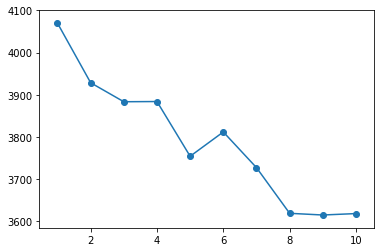

In [9]:
plt.plot(range(k_min, k_max+1), sse)
plt.scatter(range(k_min, k_max+1), sse)

We can see the elbow at k = 8, so we'll move forward with 8 clusters.

In [10]:
k = 8
km = KMeans(n_clusters=k, random_state=123)
km.fit(tfidf_mat)
product_data['cluster'] = km.labels_

In [11]:
Counter(km.labels_)

Counter({0: 149, 1: 73, 2: 110, 3: 223, 4: 65, 5: 3169, 6: 145, 7: 206})

In [12]:
def extract_cluster_top_words(names, stopwords, top_words):
    words = [word for name in names for word in name.split(' ')]
    words_clean = [word for word in words if is_clean_word(word, stopwords)]
    words_clean_counter = Counter(words_clean)
    most_common = [word for word in dict(words_clean_counter.most_common(20)).keys() if word not in top_words]
    return most_common

In [13]:
for cluster in list(set(product_data.cluster)):
    print cluster
    top_cluster_words = extract_cluster_top_words(product_data.product_name[product_data.cluster == cluster],
                                                  list(ntlk_stopwords), top_words)
    print top_cluster_words

0
[u'Umbrella', u'Catherine', u'Choice', u'Oversize', u'Sunglasses', u'Malandrino']
1
[u'White', u'Earbuds', u'CYLO']
2
[u'Winter', u'Spring']
3
[u'Beanie', u'Sunglasses', u'Tote', u'Gold', u'Weekender', u'Sun', u'Rose', u'Blanket', u'Felt', u'Yoga', u'Bag', u'Clutch', u'Necklace', u'Towel', u'Beach', u'Candle', u'Hat', u'Throw']
4
[u'Legging', u'Magic', u'Electric', u'For', u'People', u'Tank', u'Accessories', u'Moonshadow', u'Jacket', u'Fierce', u'Method', u'Free', u'Lemons', u'Love', u'Yoga', u'Pack', u'Fame', u'Bra', u'Undie']
5
[u'Body', u'Set', u'Tote', u'Beauty', u'Duo', u'Mask', u'Kit', u'Bag', u'Oil', u'Lip', u'Necklace', u'Black', u'The', u'Raga', u'Cream']
6
[u'Ultimate', u'Trio', u'Eye', u'Complete', u'Gift', u'Duo', u'Shimmy', u'Dynamic', u'Contour', u'ISH', u'Lip', u'Stick', u'Line', u'Face', u'Arch', u'Shadow', u'You', u'Brush']
7
[u'Shoulder', u'White', u'Off', u'Neck', u'Sleeve', u'Hole', u'Top', u'Cap', u'Crew', u'Bodysuit', u'Cami', u'Black', u'Mock', u'Line', u'Strap

In [14]:
sale_data = sale_data.merge(product_data[['product_id', 'cluster']], on='product_id', how='left')
sale_summary = sale_data[['product_name', 'quantity']].groupby(['product_name']).sum()
sale_summary = sale_summary.merge(product_data[['product_name', 'cluster']], 
                                  right_on='product_name', left_index=True, how='left')
sale_summary.head()

,quantity,product_name,cluster
3071,28,10 Degrees Cooler 01 Luminous Face Oil,5
3072,28,10 Degrees Cooler 03 Midnight in Corsia Face Oil,5
4007,23,8 Other Reasons Capri Crawlers,5
4008,20,8 Other Reasons Gemmy Larait,5
4009,93,AHAVA Body Lotion Trio,5


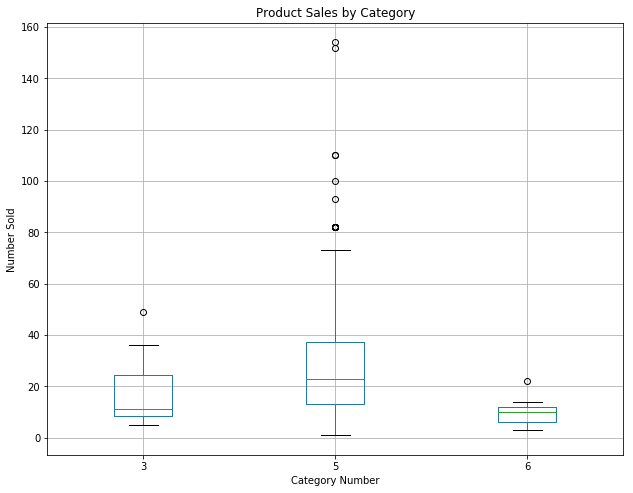

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sale_summary.boxplot(column=['quantity'], by='cluster', ax=ax)
plt.suptitle('')
plt.title('Product Sales by Category')
ax.set_xlabel('Category Number')
ax.set_ylabel('Number Sold')
plt.rcParams.update({'font.size': 5})

Visually, it seems Category 5 has higher sales on average. We can run a quick ANOVA to check if there's a significant difference in group means between these three categories.

In [16]:
cat_accessories = sale_summary[sale_summary.cluster == 3]
cat_body = sale_summary[sale_summary.cluster == 5]
cat_beauty = sale_summary[sale_summary.cluster == 6]

stats.f_oneway(cat_accessories['quantity'], cat_body['quantity'], cat_beauty['quantity'])

F_onewayResult(statistic=5.725902268068254, pvalue=0.0036414743580201357)